### **Nome:** Jhonatan Guilherme de Oliveira Cunha
### **RA:** 2135590

### **Trabalho de Aprendizado de Máquina**

Nosso objetivo aqui é responder a seguinte pergunta: "que pessoas tinham  mais chances de sobreviver ao naufrágio do Titanic".

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import ttest_ind_from_stats

%matplotlib inline

#### Logo abaixo realizamos a leitura de nossa base de dados *csv*, descartando atributos que não são importantes para a nossa análise (PassengerId e Name).

#### Obtemos o DataFrame **X** e nosso array de saída **y**

In [60]:
df = pd.read_csv('train.csv')
df.drop(['PassengerId','Name'], axis=1, inplace=True)

y = df['Survived'].values.ravel()
X = df.drop('Survived', axis=1)

#### Como podemos visualizar abaixo, nosso DataFrame possui valores faltantes. Sendo assim, deveremos realizar a técnica de imputação de dados, com objetivo de realizar uma analise mais adequada em nossos dados.

In [61]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### 1. Limpe a base de dados. Nesta etapa você deve decidir o que fazer com as instâncias que possuem dados faltantes: preencher os dados faltantes de acordo com alguma regra? Descartar as instâncias que possuem dados faltantes?

In [62]:
print("Dados faltantes: %d" % df.isnull().sum().sum())

# Técnica - "Inputação" de valores
numeric_atb = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
string_atb = ['Ticket', 'Cabin']
cat_atb = ['Sex', 'Embarked']

transformers = [
    ['imp_num', SimpleImputer(strategy="mean"), numeric_atb],
    ['imp_str', SimpleImputer(strategy="most_frequent"), string_atb],
    ['imp_cat', SimpleImputer(strategy="constant", fill_value="unknown"), cat_atb]
]

ct_imp = ColumnTransformer(
    transformers, remainder='passthrough'
)

# Realizando inputação de dados
X_imp = ct_imp.fit_transform(X)

# Convertendo resultado para um pandas DF
X_imputed = pd.DataFrame(X_imp, columns=[*numeric_atb, *string_atb, *cat_atb])
X_imputed

Dados faltantes: 866


Pclass        Age SibSp Parch     Fare            Ticket    Cabin     Sex  \
0      3.0       22.0   1.0   0.0     7.25         A/5 21171  B96 B98    male   
1      1.0       38.0   1.0   0.0  71.2833          PC 17599      C85  female   
2      3.0       26.0   0.0   0.0    7.925  STON/O2. 3101282  B96 B98  female   
3      1.0       35.0   1.0   0.0     53.1            113803     C123  female   
4      3.0       35.0   0.0   0.0     8.05            373450  B96 B98    male   
..     ...        ...   ...   ...      ...               ...      ...     ...   
886    2.0       27.0   0.0   0.0     13.0            211536  B96 B98    male   
887    1.0       19.0   0.0   0.0     30.0            112053      B42  female   
888    3.0  29.699118   1.0   2.0    23.45        W./C. 6607  B96 B98  female   
889    1.0       26.0   0.0   0.0     30.0            111369     C148    male   
890    3.0       32.0   0.0   0.0     7.75            370376  B96 B98    male   

    Embarked  
0          S  
1          C  
2          S  
3          S  
4          S  
..       ...  
886        S  
887        S  
888        S  
889        C  
890        Q  

[891 rows x 9 columns]

#### Podemos verificar abaixo que resolvemos os problemas dos atributos faltantes

In [63]:
X_imputed.isnull().sum()

Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
Ticket      0
Cabin       0
Sex         0
Embarked    0
dtype: int64

### 2. Faça a conversão dos atributos categóricos em atributos numéricos. Estas conversões devem ser realizadas considerando se o atributo categórico é ordinal ou não.

#### Após a imputação dos dados faltantes nosso DataFrame ficará da seguinte form (veja abaixo):

In [64]:
X_imputed

Pclass        Age SibSp Parch     Fare            Ticket    Cabin     Sex  \
0      3.0       22.0   1.0   0.0     7.25         A/5 21171  B96 B98    male   
1      1.0       38.0   1.0   0.0  71.2833          PC 17599      C85  female   
2      3.0       26.0   0.0   0.0    7.925  STON/O2. 3101282  B96 B98  female   
3      1.0       35.0   1.0   0.0     53.1            113803     C123  female   
4      3.0       35.0   0.0   0.0     8.05            373450  B96 B98    male   
..     ...        ...   ...   ...      ...               ...      ...     ...   
886    2.0       27.0   0.0   0.0     13.0            211536  B96 B98    male   
887    1.0       19.0   0.0   0.0     30.0            112053      B42  female   
888    3.0  29.699118   1.0   2.0    23.45        W./C. 6607  B96 B98  female   
889    1.0       26.0   0.0   0.0     30.0            111369     C148    male   
890    3.0       32.0   0.0   0.0     7.75            370376  B96 B98    male   

    Embarked  
0          S  
1          C  
2          S  
3          S  
4          S  
..       ...  
886        S  
887        S  
888        S  
889        C  
890        Q  

[891 rows x 9 columns]

#### Devemos realizar a conversão dos atributos catégoricos, sendo assim, conforme pode ser visto na Tabela Pandas abaixo, os atributos 'Sex', 'Embarked', 'Cabin', 'Ticket' não possuem relação de ordem, ou seja, utilizaremos o *OneHotEncoder*. Por conseguinte, para o atributo Pclass, utilizaremos o *OrdinalEncoder*, pois o mesmo possui uma ordem de relação, ou seja, 1 (Rico), 2 (Classe Média) e 3 (Pobre).

In [65]:
df_tf = X_imputed[['Sex', 'Embarked', 'Cabin', 'Ticket', 'Pclass']]
df_tf

Sex Embarked    Cabin            Ticket Pclass
0      male        S  B96 B98         A/5 21171    3.0
1    female        C      C85          PC 17599    1.0
2    female        S  B96 B98  STON/O2. 3101282    3.0
3    female        S     C123            113803    1.0
4      male        S  B96 B98            373450    3.0
..      ...      ...      ...               ...    ...
886    male        S  B96 B98            211536    2.0
887  female        S      B42            112053    1.0
888  female        S  B96 B98        W./C. 6607    3.0
889    male        C     C148            111369    1.0
890    male        Q  B96 B98            370376    3.0

[891 rows x 5 columns]

In [66]:
# Realizando a conversão dos atributos
transformers_imput_oe = [
    
    ('oh_pclass', OrdinalEncoder(categories=[[1, 2, 3]]), ['Pclass']),
    ('oh_sex', OneHotEncoder(), ['Sex']),
    ('oh_embarked', OneHotEncoder(), ['Embarked']),
    ('oh_cabin', OneHotEncoder(), ['Cabin']),
    ('oh_ticket', OneHotEncoder(), ['Ticket']),

]

ct_imput_ohoe = ColumnTransformer(
    transformers_imput_oe, remainder='passthrough'
)

X_imput_ohoe = ct_imput_ohoe.fit_transform(X_imputed).todense()
X_imput_ohoe

matrix([[ 2.    ,  0.    ,  1.    , ...,  1.    ,  0.    ,  7.25  ],
        [ 0.    ,  1.    ,  0.    , ...,  1.    ,  0.    , 71.2833],
        [ 2.    ,  1.    ,  0.    , ...,  0.    ,  0.    ,  7.925 ],
        ...,
        [ 2.    ,  1.    ,  0.    , ...,  1.    ,  2.    , 23.45  ],
        [ 0.    ,  0.    ,  1.    , ...,  0.    ,  0.    , 30.    ],
        [ 2.    ,  0.    ,  1.    , ...,  0.    ,  0.    ,  7.75  ]])

### 4. Normalize os dados de acordo com o que estudamos na aula.

In [67]:
ss = StandardScaler()
ss.fit(X_imput_ohoe)
X_ss = ss.transform(X_imput_ohoe)
X_ss_df = pd.DataFrame(X_ss)


### 5. Visualize o espaço de características usando a técnica PCA. Isto dará uma idéia da separabilidade das classes a partir dos atributos que você escolheu.

In [68]:
pca_ss = PCA(n_components=2)
pca_ss.fit(X_ss)
X_ss_pca = pca_ss.transform(X_ss)
X_ss_pca_pd_df = pd.DataFrame(X_ss_pca, columns=['PC 0', 'PC 1'])
X_ss_pca_pd_df

PC 0      PC 1
0   -1.914813  0.286025
1    5.268339 -0.890263
2   -0.767918 -1.558069
3    2.644009  0.142499
4   -1.757106  0.982865
..        ...       ...
886 -1.229604  1.061448
887  2.412259 -1.065716
888 -0.482896 -2.508499
889  2.981147  3.573419
890 -1.493773  0.241285

[891 rows x 2 columns]

<AxesSubplot:xlabel='PC 0', ylabel='PC 1'>

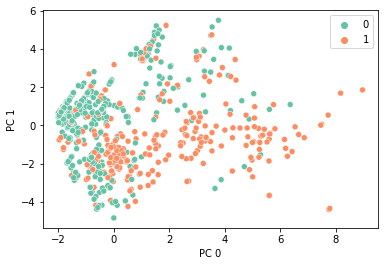

In [69]:
sns.set_palette('seismic')
sns.scatterplot(data=X_ss_pca_pd_df, x='PC 0', y='PC 1', hue=y, palette='Set2')

### 6. Utilize ambos classificadores estudados até o momento: KNN e SVM. Os hiperparâmetros devem ser selecionados usando o processo de validação cruzada, descrito a seguir.

#### Após realizarmos todos os tratamentos em nossos dados, podemos começar o processo de classificação para treinar e obter nosso melhor modelo

In [100]:
from do_svm7777 import do_cv_svm
from do_knn7777 import do_cv_knn

svm, best_params_svm = do_cv_svm(X_imput_ohoe, y, 10, 5, params={'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale', 2e-2, 2e-3, 2e-4], 'kernel': ['rbf']}, n_jobs=8)
knn, best_params_knn = do_cv_knn(X_imput_ohoe, y, 10, 5, params={'n_neighbors' : range(1,30,2)}, n_jobs=8)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

#### Os melhores parametros para o modelo treinado com o KNN foram:

In [115]:
best_params_knn[max(best_params_knn)][0]

{'n_neighbors': 3}

#### Os melhores parametros para o modelo treinado com o KNN foram:

In [116]:
best_params_svm[max(best_params_svm)][0]

{'C': 1000, 'gamma': 0.0002, 'kernel': 'rbf'}

#### No código abaixo, construimos um DataFrame Pandas para para conseguirmos visualizar as acurácias de forma simplificada

In [78]:
target = 'f1-score'
svm_result = []
knn_result = []

for fold in svm:
  svm_result.append([fold['weighted avg'][target], fold['0'][target], fold['1'][target]])

for fold in knn:
  knn_result.append([fold['weighted avg'][target], fold['0'][target], fold['1'][target]])
  
svm_pd_table = pd.DataFrame(svm_result, columns=['Weighted AVG', 'Classe 0', 'Classe 1'])
knn_pd_table = pd.DataFrame(knn_result, columns=['Weighted AVG', 'Classe 0', 'Classe 1'])

knn_classe0_f1_score = knn_pd_table['Classe 0']
knn_classe1_f1_score = knn_pd_table['Classe 1']
knn_f1_score = knn_pd_table['Weighted AVG']

svm_classe0_f1_score = svm_pd_table['Classe 0']
svm_classe1_f1_score = svm_pd_table['Classe 1']
svm_f1_score = svm_pd_table['Weighted AVG']


### 8. Selecione o melhor modelo gerado usando análise estatística do desempenho obtido pelos classificadores durante a validação cruzada. Faça esta seleção de forma automática!

In [79]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))
    
def rejeitar_hip_nula(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2, alpha=0.05):
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2)
    return pvalor <= alpha

In [80]:
media_knn, std_knn, _, _ = calcular_estatisticas(knn_f1_score)
media_svm, std_svm, _, _ = calcular_estatisticas(svm_f1_score)

_, pvalor = ttest_ind_from_stats(media_knn, std_knn, len(knn_f1_score), media_svm, std_svm, len(svm_f1_score))

In [81]:
pvalor

0.00021279320022076956

### Como o pvalor é menor que 0.05 podemos afirmar que um dos modelos treinados é significativamente melhor que o outro

In [82]:
pvalor<=0.05

True

In [83]:
rejeitar_hip_nula(media_knn, std_knn, len(knn_f1_score), media_svm, std_svm, len(svm_f1_score))

True

#### Como a hipotese nula foi rejeitada, afirmamos que existe uma diferença estatisticas significativa entre os dois classificadores

### 9. Apresente os resultados da classificação com todos os modelos, apresentando as métricas de classificação por classe e também da classificação como um todo.

### KNN - Tabela Pandas

In [84]:
knn_pd_table

Weighted AVG  Classe 0  Classe 1
0      0.774942  0.824561  0.696970
1      0.776410  0.814815  0.714286
2      0.770219  0.827586  0.677419
3      0.782686  0.834783  0.698413
4      0.670963  0.743363  0.553846
5      0.761732  0.814159  0.676923
6      0.761732  0.814159  0.676923
7      0.765722  0.803738  0.704225
8      0.752809  0.800000  0.676471
9      0.728823  0.781818  0.647059

### Estatisticas KNN

In [85]:
print("KNN F1-SCORE - CLASSE 0")
imprimir_estatisticas(knn_classe0_f1_score)
print()


print("KNN F1-SCORE - CLASSE 1")
imprimir_estatisticas(knn_classe1_f1_score)
print()


print("KNN F1-SCORE")
imprimir_estatisticas(knn_f1_score)
print()


KNN F1-SCORE - CLASSE 0
Resultados: 0.81 +- 0.03, min: 0.74, max: 0.83

KNN F1-SCORE - CLASSE 1
Resultados: 0.67 +- 0.04, min: 0.55, max: 0.71

KNN F1-SCORE
Resultados: 0.75 +- 0.03, min: 0.67, max: 0.78



### SVM - Tabela Pandas

In [86]:
svm_pd_table

Weighted AVG  Classe 0  Classe 1
0      0.798845  0.839286  0.735294
1      0.852501  0.884956  0.800000
2      0.794981  0.842105  0.718750
3      0.932584  0.945455  0.911765
4      0.796494  0.839286  0.727273
5      0.862131  0.896552  0.806452
6      0.772201  0.824561  0.687500
7      0.830962  0.864865  0.776119
8      0.840541  0.877193  0.781250
9      0.851546  0.884956  0.800000

### Estatisticas SVM

In [87]:
print("SVM F1-SCORE - CLASSE 0")
imprimir_estatisticas(svm_classe0_f1_score)
print()

print("SVM F1-SCORE - CLASSE 1")
imprimir_estatisticas(svm_classe1_f1_score)
print()


print("SVM F1-SCORE")
imprimir_estatisticas(svm_f1_score)
print()


SVM F1-SCORE - CLASSE 0
Resultados: 0.87 +- 0.03, min: 0.82, max: 0.95

SVM F1-SCORE - CLASSE 1
Resultados: 0.77 +- 0.06, min: 0.69, max: 0.91

SVM F1-SCORE
Resultados: 0.83 +- 0.04, min: 0.77, max: 0.93



### Conclusão

#### Sendo assim, com base na média da classificação como um todo, afirmo que o modelo treinado utilizando o classificador SVM é melhor que o treinado com o KNN